# SemEval-2017 Task 4 – Subtask A (English Twitter)
## Deep Learning Project – BERTweet & RoBERTa Fine-tuning

This notebook implements the complete pipeline for **Subtask A** (tweet-level sentiment: negative / neutral / positive):

- Loads the official **SemEval-2017 Task 4** English data from `2017_English_final.zip`.
- Builds **train / dev / test** splits from `GOLD/Subtask_A` Twitter files.
- Applies light tweet preprocessing (`<URL>`, `<USER>` placeholders).
- Fine-tunes two transformer models:
  - `vinai/bertweet-base`
  - `roberta-base`
- Uses:
  - Learning rate **2e-5**
  - Weight decay **0.01**
  - **5% warmup** for the learning rate schedule
  - Increased dropout (**0.2**) in the encoder
  - **Early stopping** based on dev AvgRec (patience = 2)
- Evaluates on the 2016 Twitter test set.
- Saves:
  - Best checkpoints: `bertweet_subtaskA_best/`, `roberta_subtaskA_best/`
  - All models: `saved_models_subtaskA/`
  - Metrics CSVs: `history_subtaskA_all.csv`, `test_results_subtaskA.csv`


**Group Members:**

- Teuku Achmad Ra’di Syah (23/511627/PA/21833)  
- Raditya Maheswara (23/516252/PA/22075)  
- Muhammad Rafif Akio Sarwadi (23/511466/PA/21802)  

---

## How to Run This Notebook

### 1. Setup & Data

1. Run **Section 0** (Install dependencies) – only needed once per Colab session.  
2. Run **Section 1–4** in order:
   - Imports, device, hyperparameters  
   - Upload `2017_English_final.zip` when prompted in **Section 2**  
   - Build train/dev/test splits and remove leakage (**Sections 3–4**)  

### 2. Choose Mode: Debug Run vs Full Training

There is a **DEBUG block** in Section **7.5**:

```python
DEBUG = True  # set False for full training

if DEBUG:
    df_train_debug = df_train.sample(n=500, random_state=42)
    df_dev_debug   = df_dev.sample(n=500, random_state=42)
    EPOCHS_DEBUG = 1
else:
    df_train_debug = df_train
    df_dev_debug   = df_dev
    EPOCHS_DEBUG = EPOCHS


### 0. Install dependencies

In [ ]:

# ============================================================
# 0. Install dependencies (run once per Colab session)
# ============================================================
# In Google Colab, this will install the required libraries.
!pip install -q transformers emoji scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 13.1 MB/s eta 0:00:00


### 1. Imports, device setup, and global configuration

In [ ]:

# ============================================================
# 1. Imports, device setup, and global configuration
# ============================================================
import os, re, zipfile, random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    get_linear_schedule_with_warmup,
)

from tqdm.auto import tqdm

# ---------------- Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------- Seed ----------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# ---------------- Labels ----------------
label2id = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
}
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)

# ---------------- Hyperparameters ----------------
BATCH_SIZE   = 16      # Reduce to 16 if GPU memory is not enough
MAX_LEN      = 128      # Max token length
EPOCHS       = 4       # Max epochs; early stopping may stop earlier
LR           = 2e-5    # Slightly lower LR for stability
WEIGHT_DECAY = 0.01    # AdamW weight decay
WARMUP_RATIO = 0.05    # 5% warmup steps (changed from 0.1)
MAX_GRAD_NORM = 1.0    # Gradient clipping
PATIENCE     = 2       # Early stopping patience (epochs without dev AvgRec improvement)

print(f"Hyperparams -> LR={LR}, BATCH_SIZE={BATCH_SIZE}, MAX_LEN={MAX_LEN}, "
      f"EPOCHS={EPOCHS}, WARMUP_RATIO={WARMUP_RATIO}, PATIENCE={PATIENCE}")


Using device: cuda
Hyperparams -> LR=2e-05, BATCH_SIZE=16, MAX_LEN=128, EPOCHS=4, WARMUP_RATIO=0.05, PATIENCE=2


### 2. Upload SemEval 2017 English data zip

In [ ]:

# ============================================================
# 2. Upload SemEval 2017 English data zip
# ============================================================
# In Google Colab, this opens a file chooser. Upload:
#   2017_English_final.zip

from google.colab import files

print("Please upload 2017_English_final.zip from your computer.")
uploaded = files.upload()

# Take the first uploaded file as the zip
zip_path = next(iter(uploaded.keys()))
print("Using zip file:", zip_path)


Please upload 2017_English_final.zip from your computer.


Saving 2017_English_final.zip to 2017_English_final.zip
Using zip file: 2017_English_final.zip


### 3. Read Subtask A Twitter files and construct splits

In [ ]:

# ============================================================
# 3. Read Subtask A Twitter files from GOLD/Subtask_A
# ============================================================
GOLD_SUBTASK_A_DIR = "2017_English_final/GOLD/Subtask_A"

# Training files (Twitter only)
TRAIN_FILES = [
    "twitter-2013train-A.txt",
    "twitter-2013dev-A.txt",
    "twitter-2013test-A.txt",
    "twitter-2014sarcasm-A.txt",
    "twitter-2014test-A.txt",
    "twitter-2015train-A.txt",
    "twitter-2015test-A.txt",
    "twitter-2016train-A.txt",
    "twitter-2016devtest-A.txt",
]

# Dev file (Twitter 2016 dev)
DEV_FILES = [
    "twitter-2016dev-A.txt",
]

# Test file (Twitter 2016 test)
TEST_FILES = [
    "twitter-2016test-A.txt",
]


def read_twitter_subtask_a(zip_path: str, file_list):
    # Read SemEval Subtask A Twitter files into a DataFrame.
    # Each line: tweet_id \t label \t text
    rows = []
    with zipfile.ZipFile(zip_path, "r") as z:
        for fname in file_list:
            full_path = f"{GOLD_SUBTASK_A_DIR}/{fname}"
            with z.open(full_path) as f:
                for line in f:
                    line = line.decode("utf-8", errors="ignore").strip()
                    if not line or line == '"':
                        continue
                    parts = line.split("\t")
                    if len(parts) < 3:
                        continue
                    tweet_id, label, text = parts[0], parts[1], parts[2]
                    rows.append(
                        {
                            "tweet_id": tweet_id,
                            "label": label,
                            "text": text,
                            "source_file": fname,
                        }
                    )
    return pd.DataFrame(rows)


df_train_raw = read_twitter_subtask_a(zip_path, TRAIN_FILES)
df_dev_raw   = read_twitter_subtask_a(zip_path, DEV_FILES)
df_test_raw  = read_twitter_subtask_a(zip_path, TEST_FILES)

print("Raw train size:", len(df_train_raw))
print("Raw dev size  :", len(df_dev_raw))
print("Raw test size :", len(df_test_raw))


Raw train size: 27703
Raw dev size  : 1999
Raw test size : 20632


### 4. Deduplicate tweets and remove leakage between splits

In [ ]:

# ============================================================
# 4. Deduplicate tweets and remove leakage between splits
# ============================================================
def dedup_and_remove_leaks(df_train, df_dev, df_test):
    # Deduplicate test
    df_test = df_test.drop_duplicates("tweet_id")
    test_ids = set(df_test["tweet_id"])

    # Deduplicate dev, remove overlaps with test
    df_dev = df_dev.drop_duplicates("tweet_id")
    df_dev = df_dev[~df_dev["tweet_id"].isin(test_ids)]
    dev_ids = set(df_dev["tweet_id"])

    # Deduplicate train, remove overlaps with test and dev
    df_train = df_train.drop_duplicates("tweet_id")
    df_train = df_train[~df_train["tweet_id"].isin(test_ids)]
    df_train = df_train[~df_train["tweet_id"].isin(dev_ids)]

    return df_train.reset_index(drop=True), df_dev.reset_index(drop=True), df_test.reset_index(drop=True)


df_train, df_dev, df_test = dedup_and_remove_leaks(df_train_raw, df_dev_raw, df_test_raw)

print("After dedup & leak removal:")
print("  Train:", len(df_train))
print("  Dev  :", len(df_dev))
print("  Test :", len(df_test))


def show_label_stats(df, name):
    print(f"\n=== {name} label distribution ===")
    print(df["label"].value_counts())
    display(df["label"].value_counts(normalize=True).rename("proportion").to_frame())


show_label_stats(df_train, "Train")
show_label_stats(df_dev, "Dev")
show_label_stats(df_test, "Test")


After dedup & leak removal:
  Train: 27035
  Dev  : 1979
  Test : 20556

=== Train label distribution ===
label
positive    11758
neutral     11153
negative     4124
Name: count, dtype: int64


,proportion
label,
positive,0.434918
neutral,0.412539
negative,0.152543



=== Dev label distribution ===
label
positive    838
neutral     754
negative    387
Name: count, dtype: int64


,proportion
label,
positive,0.423446
neutral,0.381001
negative,0.195553



=== Test label distribution ===
label
neutral     10302
positive     7033
negative     3221
Name: count, dtype: int64


,proportion
label,
neutral,0.501168
positive,0.342139
negative,0.156694


### 5. Tweet preprocessing and Dataset class

In [ ]:

# ============================================================
# 5. Tweet preprocessing & Dataset class
# ============================================================
URL_RE = re.compile(r"http\S+|www\.\S+")
USER_RE = re.compile(r"@\w+")


def preprocess_tweet(text: str) -> str:
    # Simple normalization: replace URLs and @mentions with placeholders.
    text = URL_RE.sub(" <URL> ", text)
    text = USER_RE.sub(" <USER> ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


# Quick sanity check
print(preprocess_tweet("dear @Microsoft check https://t.co/abc :D #windows10"))


class TweetSentimentDataset(Dataset):
    # PyTorch Dataset for (text, label) pairs.
    def __init__(self, df, tokenizer, max_len, label2id):
        self.texts = df["text"].tolist()
        self.labels = [label2id[l] for l in df["label"]]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        raw_text = self.texts[idx]
        text = preprocess_tweet(raw_text)

        encoded = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        item = {k: v.squeeze(0) for k, v in encoded.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


dear <USER> check <URL> :D #windows10


### 6. Metrics helper functions and plotting utilities

In [ ]:

# ============================================================
# 6. Metrics and visualization helpers
# ============================================================
def compute_metrics(y_true, y_pred, label_names=("negative", "neutral", "positive")):
    # Build classification report as a dictionary
    report = classification_report(
        y_true,
        y_pred,
        target_names=list(label_names),
        output_dict=True,
        zero_division=0,
    )
    acc = accuracy_score(y_true, y_pred)

    # Macro-averaged recall across NEG/NEU/POS
    recalls = [report[label]["recall"] for label in label_names]
    avgrec = float(sum(recalls) / len(recalls))

    # F1_PN: macro F1 over Negative + Positive only
    f1_pn = (report["negative"]["f1-score"] + report["positive"]["f1-score"]) / 2.0

    metrics = {
        "accuracy": acc,
        "avgrec": avgrec,
        "f1_pn": f1_pn,
        "report": report,
    }
    return metrics


def plot_confusion_matrix(cm, labels, title):
    # Basic confusion matrix heatmap for visual inspection.
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=labels,
        yticklabels=labels,
        ylabel="True label",
        xlabel="Predicted label",
        title=title,
    )

    fmt = "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    fig.tight_layout()
    plt.show()


def plot_history(history_df, model_name):
    # Plot loss and dev metrics vs epoch for a given model.
    df = history_df[history_df["model_name"] == model_name]

    # Loss vs epoch
    plt.figure()
    plt.plot(df["epoch"], df["train_loss"], marker="o", label="train_loss")
    plt.plot(df["epoch"], df["dev_loss"], marker="o", label="dev_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epoch ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Dev metrics vs epoch
    plt.figure()
    plt.plot(df["epoch"], df["dev_accuracy"], marker="o", label="dev_accuracy")
    plt.plot(df["epoch"], df["dev_avgrec"], marker="o", label="dev_avgrec")
    plt.plot(df["epoch"], df["dev_f1_pn"], marker="o", label="dev_f1_pn")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"Dev metrics vs Epoch ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.show()


### 7. Dataloaders, training loop, and evaluation loop

In [ ]:

# ============================================================
# 7. Dataloaders, training loop, and evaluation loop
# ============================================================
def create_data_loader(df, tokenizer, max_len, batch_size, label2id):
    dataset = TweetSentimentDataset(df, tokenizer, max_len, label2id)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


def train_one_epoch(model, data_loader, optimizer, scheduler, device, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0

    # tqdm progress bar over batches
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        loss = outputs.loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(data_loader)
    return avg_loss


def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            labels = batch["labels"].to(device)
            inputs = {
                "input_ids": batch["input_ids"].to(device),
                "attention_mask": batch["attention_mask"].to(device),
            }

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            all_labels.extend(labels.cpu().numpy().tolist())
            all_preds.extend(preds.cpu().numpy().tolist())

            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(data_loader)
    return avg_loss, np.array(all_labels), np.array(all_preds)


7.5 DEBUG MODE TESTING CODE AND MAKING GOOD PIPELINE


In [ ]:
# ============================================================
# DEBUG MODE: gunakan subset kecil + 1 epoch
# ============================================================

DEBUG = False  # set  False IF NO ACTUALLY TESTING PLEASE

if DEBUG:
    # kecilkan df_train & df_dev
    df_train_debug = df_train.sample(n=500, random_state=42)   # bebas mau 500 / 1000 / 2000
    df_dev_debug   = df_dev.sample(n=500, random_state=42)
    EPOCHS_DEBUG = 1
else:
    df_train_debug = df_train
    df_dev_debug   = df_dev
    EPOCHS_DEBUG = EPOCHS

### 8. Training function for each model (dropout + early stopping)

In [ ]:

# ============================================================
# 8. Training function for a single model (with higher dropout + early stopping)
# ============================================================
def run_experiment(model_name: str, df_train, df_dev,
                   max_len=MAX_LEN, batch_size=BATCH_SIZE,
                   lr=LR, weight_decay=WEIGHT_DECAY,
                   epochs=EPOCHS, warmup_ratio=WARMUP_RATIO,
                   max_grad_norm=MAX_GRAD_NORM, patience=PATIENCE):
    print(f"\n===== Training {model_name} on Subtask A =====")

    # BERTweet uses a non-fast tokenizer
    use_fast = False if "bertweet" in model_name.lower() else True

    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        use_fast=use_fast,
    )

    # Custom config: set num_labels and increase dropout
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = num_labels
    config.id2label = id2label
    config.label2id = label2id
    # Increase dropout to help regularization
    if hasattr(config, "hidden_dropout_prob"):
        config.hidden_dropout_prob = 0.2
    if hasattr(config, "attention_probs_dropout_prob"):
        config.attention_probs_dropout_prob = 0.2

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )
    model.to(device)

    train_loader = create_data_loader(df_train, tokenizer, max_len, batch_size, label2id)
    dev_loader   = create_data_loader(df_dev,   tokenizer, max_len, batch_size, label2id)

    total_steps = len(train_loader) * epochs
    warmup_steps = int(warmup_ratio * total_steps)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    history = []
    best_dev_avgrec = -1.0
    best_state_dict = None
    epochs_no_improve = 0

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss = train_one_epoch(
            model, train_loader, optimizer, scheduler, device, max_grad_norm
        )
        print(f"  Train loss: {train_loss:.4f}")

        dev_loss, dev_y_true, dev_y_pred = eval_model(model, dev_loader, device)
        dev_metrics = compute_metrics(dev_y_true, dev_y_pred)

        print(f"  Dev loss   : {dev_loss:.4f}")
        print(f"  Dev Acc    : {dev_metrics['accuracy']:.4f}")
        print(f"  Dev AvgRec : {dev_metrics['avgrec']:.4f}")
        print(f"  Dev F1_PN  : {dev_metrics['f1_pn']:.4f}")

        history.append({
            "model_name": model_name,
            "epoch": epoch,
            "train_loss": train_loss,
            "dev_loss": dev_loss,
            "dev_accuracy": dev_metrics["accuracy"],
            "dev_avgrec": dev_metrics["avgrec"],
            "dev_f1_pn": dev_metrics["f1_pn"],
            "lr": lr,
            "max_len": max_len,
            "batch_size": batch_size,
        })

        # Early stopping based on AvgRec
        if dev_metrics["avgrec"] > best_dev_avgrec:
            best_dev_avgrec = dev_metrics["avgrec"]
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
            print(f"  --> New best dev AvgRec: {best_dev_avgrec:.4f}")

        else:
            epochs_no_improve += 1
            print(f"  No improvement in AvgRec for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    history_df = pd.DataFrame(history)

    # Restore best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)

    return model, tokenizer, history_df


### 9. Run experiments for BERTweet and RoBERTa

In [ ]:

# ============================================================
# 9. Run experiments for BERTweet and RoBERTa
# ============================================================
set_seed(42)

MODEL_NAMES = [
    "vinai/bertweet-base",
    "roberta-base",
]

all_histories = []
models = {}
tokenizers = {}

for mname in MODEL_NAMES:
    model, tokenizer, hist_df = run_experiment(
        model_name=mname,
        df_train=df_train_debug, #Change df_train_debug for debuggin and if real test run df_train
        df_dev=df_dev_debug, #Change df_dev_debug for debuggin and if real test run df_dev_debug
        max_len=MAX_LEN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS_DEBUG, #Change EPOCHS_DEBUG for debuggin and if real test run EPOCHS_DEBUG
    )
    models[mname] = model
    tokenizers[mname] = tokenizer
    all_histories.append(hist_df)

history_all = pd.concat(all_histories, ignore_index=True)
print("\n=== Training history (all models) ===")
display(history_all)



===== Training vinai/bertweet-base on Subtask A =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]


Epoch 1/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.7248


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.8190
  Dev Acc    : 0.6175
  Dev AvgRec : 0.6298
  Dev F1_PN  : 0.6526
  --> New best dev AvgRec: 0.6298

Epoch 2/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.5338


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.8738
  Dev Acc    : 0.6266
  Dev AvgRec : 0.6298
  Dev F1_PN  : 0.6477
  --> New best dev AvgRec: 0.6298

Epoch 3/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.4406


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.9731
  Dev Acc    : 0.6291
  Dev AvgRec : 0.6480
  Dev F1_PN  : 0.6672
  --> New best dev AvgRec: 0.6480

Epoch 4/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.3727


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.9857
  Dev Acc    : 0.6438
  Dev AvgRec : 0.6549
  Dev F1_PN  : 0.6812
  --> New best dev AvgRec: 0.6549

===== Training roberta-base on Subtask A =====


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.7295


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.8243
  Dev Acc    : 0.6089
  Dev AvgRec : 0.6244
  Dev F1_PN  : 0.6552
  --> New best dev AvgRec: 0.6244

Epoch 2/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.5811


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.8518
  Dev Acc    : 0.6246
  Dev AvgRec : 0.6146
  Dev F1_PN  : 0.6470
  No improvement in AvgRec for 1 epoch(s).

Epoch 3/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.5126


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.8615
  Dev Acc    : 0.6256
  Dev AvgRec : 0.6315
  Dev F1_PN  : 0.6604
  --> New best dev AvgRec: 0.6315

Epoch 4/4


Training:   0%|          | 0/1690 [00:00<?, ?it/s]

  Train loss: 0.4568


Evaluating:   0%|          | 0/124 [00:00<?, ?it/s]

  Dev loss   : 0.9098
  Dev Acc    : 0.6372
  Dev AvgRec : 0.6461
  Dev F1_PN  : 0.6743
  --> New best dev AvgRec: 0.6461

=== Training history (all models) ===


,model_name,epoch,train_loss,dev_loss,dev_accuracy,dev_avgrec,dev_f1_pn,lr,max_len,batch_size
0,vinai/bertweet-base,1,0.724775,0.819023,0.617484,0.629826,0.652585,0.00002,128,16
1,vinai/bertweet-base,2,0.533753,0.873799,0.626579,0.629845,0.647723,0.00002,128,16
2,vinai/bertweet-base,3,0.440649,0.973083,0.629106,0.648003,0.667233,0.00002,128,16
3,vinai/bertweet-base,4,0.372689,0.985677,0.643759,0.654948,0.681224,0.00002,128,16
4,roberta-base,1,0.729544,0.824313,0.608893,0.624372,0.655207,0.00002,128,16
5,roberta-base,2,0.581110,0.851777,0.624558,0.614599,0.646971,0.00002,128,16
6,roberta-base,3,0.512597,0.861475,0.625568,0.631462,0.660406,0.00002,128,16
7,roberta-base,4,0.456800,0.909767,0.637191,0.646129,0.674316,0.00002,128,16


### 10. Plot training and validation curves

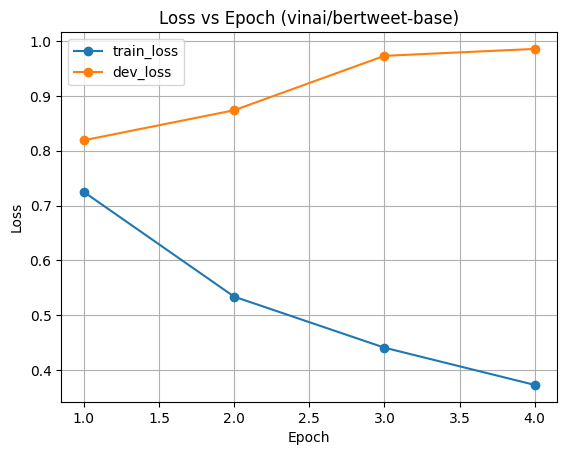

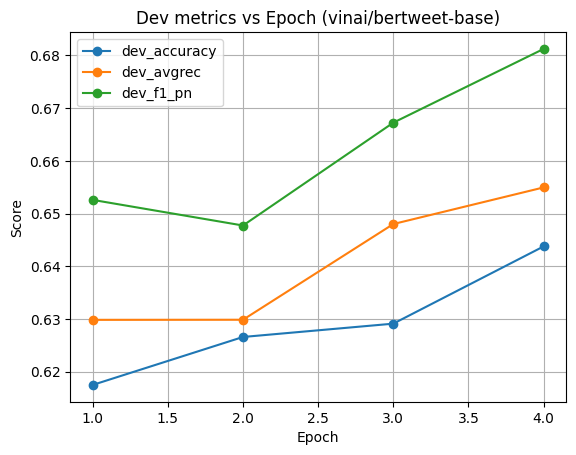

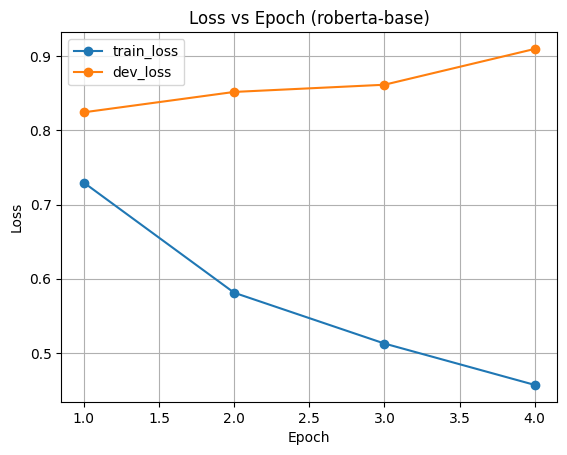

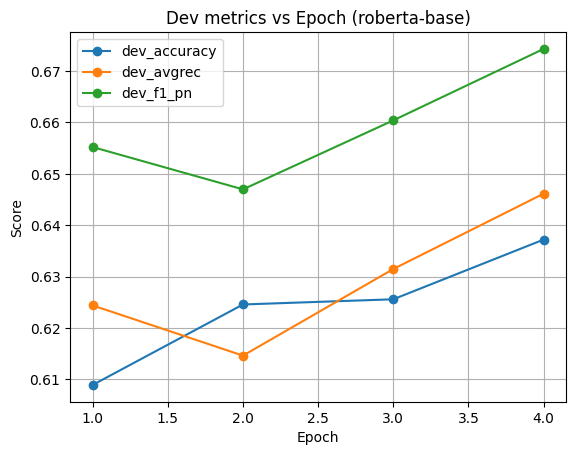

In [ ]:

# ============================================================
# 10. Plot training & validation curves for each model
# ============================================================
for mname in MODEL_NAMES:
    plot_history(history_all, mname)


### 11. Final evaluation on test set (2016 Twitter test)


===== Final evaluation on TEST for vinai/bertweet-base =====


Evaluating:   0%|          | 0/1285 [00:00<?, ?it/s]

Test loss  : 0.8913
Test Acc   : 0.6745
Test AvgRec: 0.7210
Test F1_PN : 0.6979

Classification report:


,precision,recall,f1-score,support
negative,0.576793,0.796337,0.669014,3221.000000
neutral,0.795692,0.516405,0.626324,10302.000000
positive,0.634617,0.850277,0.726787,7033.000000
accuracy,0.674499,0.674499,0.674499,0.674499
macro avg,0.669034,0.721006,0.674042,20556.000000
weighted avg,0.706282,0.674499,0.667386,20556.000000



Confusion matrix (counts):


,pred_neg,pred_neu,pred_pos
true_neg,2565,483,173
true_neu,1712,5320,3270
true_pos,170,883,5980


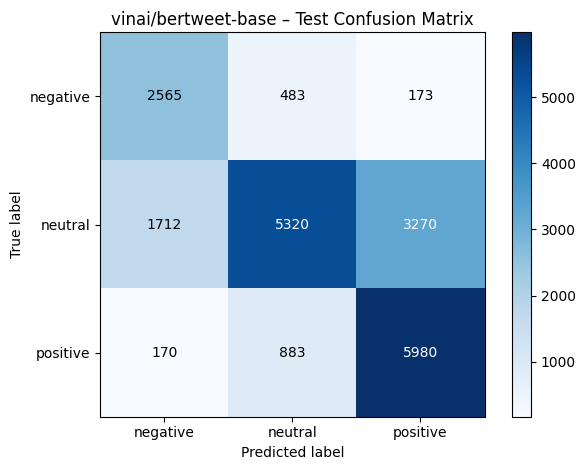


===== Final evaluation on TEST for roberta-base =====


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:

# ============================================================
# 11. Final evaluation on TEST set (2016 Twitter test)
# ============================================================

EVAL_FROM_SAVED_DIR = True  # True kalau mau eval dari direktori, bukan dari `models[...]`

EVAL_MODEL_DIRS = {
    "vinai/bertweet-base": "continued_from_best_subtaskA_vinai_bertweet-base//",                 # best dari training awal
    "roberta-base": "continued_from_best_subtaskA_roberta-base/",
    # Contoh: kalau mau eval continued model:
    # "vinai/bertweet-base": "continued_from_best_subtaskA_vinai_bertweet-base/",
    # "roberta-base": "continued_from_best_subtaskA_roberta-base/",
    # "vinai/bertweet-base": "bertweet_subtaskA_best/",
    # "roberta-base": "roberta_subtaskA_best/",

}

test_results = []

for mname in MODEL_NAMES:
    print(f"\n===== Final evaluation on TEST for {mname} =====")

    if EVAL_FROM_SAVED_DIR:
        # Load model & tokenizer dari direktori yang ditentukan
        eval_dir = EVAL_MODEL_DIRS[mname]
        use_fast = False if "bertweet" in mname.lower() else True
        tokenizer = AutoTokenizer.from_pretrained(eval_dir, use_fast=use_fast)
        model = AutoModelForSequenceClassification.from_pretrained(eval_dir).to(device)

    else:
        # Pakai model hasil training di RAM (dari cell 9 atau 14)
        model = models[mname]
        tokenizer = tokenizers[mname]

    test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, label2id)
    test_loss, y_true, y_pred = eval_model(model, test_loader, device)
    metrics = compute_metrics(y_true, y_pred)

    print(f"Test loss  : {test_loss:.4f}")
    print(f"Test Acc   : {metrics['accuracy']:.4f}")
    print(f"Test AvgRec: {metrics['avgrec']:.4f}")
    print(f"Test F1_PN : {metrics['f1_pn']:.4f}")

    # Classification report as a DataFrame
    report_df = pd.DataFrame(metrics["report"]).T
    print("\nClassification report:")
    display(report_df)

    # Confusion matrix (counts)
    cm = confusion_matrix(
        y_true,
        y_pred,
        labels=[label2id["negative"], label2id["neutral"], label2id["positive"]],
    )
    cm_df = pd.DataFrame(
        cm,
        index=["true_neg", "true_neu", "true_pos"],
        columns=["pred_neg", "pred_neu", "pred_pos"],
    )
    print("\nConfusion matrix (counts):")
    display(cm_df)

    plot_confusion_matrix(cm, ["negative", "neutral", "positive"],
                          title=f"{mname} – Test Confusion Matrix")

    test_results.append({
        "model_name": mname,
        "test_loss": test_loss,
        "test_accuracy": metrics["accuracy"],
        "test_avgrec": metrics["avgrec"],
        "test_f1_pn": metrics["f1_pn"],
    })

test_results_df = pd.DataFrame(test_results)
print("\n===== Summary of TEST metrics by model =====")
display(test_results_df)


### 12. Save models, best checkpoints, and metrics

In [ ]:

# ============================================================
# 12. Save models, best checkpoints, and CSV metrics
# ============================================================
import os

# 1) Save each model in a separate folder under saved_models_subtaskA/
base_dir = "saved_models_subtaskA"
os.makedirs(base_dir, exist_ok=True)

for mname in MODEL_NAMES:
    clean_name = mname.replace("/", "_")
    model_dir = os.path.join(base_dir, clean_name)
    os.makedirs(model_dir, exist_ok=True)
    print("Saving", mname, "to", model_dir)
    models[mname].save_pretrained(model_dir)
    tokenizers[mname].save_pretrained(model_dir)

# 2) Save "best" checkpoints with simple names for easy reuse (inference / slides)
bertweet_name = "vinai/bertweet-base"
roberta_name = "roberta-base"

os.makedirs("bertweet_subtaskA_best", exist_ok=True)
os.makedirs("roberta_subtaskA_best", exist_ok=True)

print("Saving best BERTweet checkpoint to 'bertweet_subtaskA_best/'")
models[bertweet_name].save_pretrained("bertweet_subtaskA_best")
tokenizers[bertweet_name].save_pretrained("bertweet_subtaskA_best")

print("Saving best RoBERTa checkpoint to 'roberta_subtaskA_best/'")
models[roberta_name].save_pretrained("roberta_subtaskA_best")
tokenizers[roberta_name].save_pretrained("roberta_subtaskA_best")

# 3) Save training history & test summary as CSVs
history_path = "history_subtaskA_all.csv"
testres_path = "test_results_subtaskA.csv"

history_all.to_csv(history_path, index=False)
test_results_df.to_csv(testres_path, index=False)

print("\nSaved CSVs:")
print("  Training history ->", os.path.abspath(history_path))
print("  Test results     ->", os.path.abspath(testres_path))


Saving vinai/bertweet-base to saved_models_subtaskA/vinai_bertweet-base
Saving roberta-base to saved_models_subtaskA/roberta-base
Saving best BERTweet checkpoint to 'bertweet_subtaskA_best/'
Saving best RoBERTa checkpoint to 'roberta_subtaskA_best/'

Saved CSVs:
  Training history -> /content/history_subtaskA_all.csv
  Test results     -> /content/test_results_subtaskA.csv


Cell 13


In [ ]:
# ==== Cell 13: Load best checkpoints for BOTH models ====
from transformers import AutoTokenizer, AutoModelForSequenceClassification

BEST_DIRS = {
    "vinai/bertweet-base": "bertweet_subtaskA_best/",
    "roberta-base": "roberta_subtaskA_best/",
}

best_models = {}
best_tokenizers = {}

for mname, best_dir in BEST_DIRS.items():
    use_fast = False if "bertweet" in mname.lower() else True
    print(f"\n[LOAD BEST] {mname} from {best_dir}")
    tok = AutoTokenizer.from_pretrained(best_dir, use_fast=use_fast)
    mdl = AutoModelForSequenceClassification.from_pretrained(best_dir).to(device)
    mdl.eval()

    best_models[mname] = mdl
    best_tokenizers[mname] = tok

print("\nLoaded best models:", list(best_models.keys()))



[LOAD BEST] vinai/bertweet-base from bertweet_subtaskA_best/

[LOAD BEST] roberta-base from roberta_subtaskA_best/

Loaded best models: ['vinai/bertweet-base', 'roberta-base']


Cell 14

In [ ]:
# ==== Cell 14: Continue training BOTH models from their best checkpoints ====
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import os

def continue_training_from_best(model_name, best_dir,
                                epochs_continue=1,
                                lr_factor=0.1):
    """
    Continue training a model starting from its best checkpoint on disk.
    - model_name: HF name ("vinai/bertweet-base", "roberta-base")
    - best_dir  : folder saved in Cell 12 ("bertweet_subtaskA_best/", ...)
    - epochs_continue: how many extra epochs
    - lr_factor: new LR = LR * lr_factor
    """
    use_fast = False if "bertweet" in model_name.lower() else True

    print(f"\n=== Continue training from best checkpoint: {model_name} ===")
    print(f"Loading from: {best_dir}")

    tokenizer = AutoTokenizer.from_pretrained(best_dir, use_fast=use_fast)
    model = AutoModelForSequenceClassification.from_pretrained(
        best_dir,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    ).to(device)

    # Smaller LR for fine-tuning from best
    CONTINUE_LR = LR * lr_factor

    # Pakai subset debug kalau DEBUG=True, kalau tidak ya full df
    train_df = df_train_debug if DEBUG else df_train
    dev_df   = df_dev_debug   if DEBUG else df_dev

    train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, label2id)
    dev_loader   = create_data_loader(dev_df,   tokenizer, MAX_LEN, BATCH_SIZE, label2id)

    # --- Optimizer & scheduler untuk continued training ---
    total_steps = len(train_loader) * epochs_continue
    warmup_steps = int(WARMUP_RATIO * total_steps)

    optimizer = AdamW(model.parameters(), lr=CONTINUE_LR, weight_decay=WEIGHT_DECAY)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    # --- Baseline sebelum continued training ---
    base_loss, base_y_true, base_y_pred = eval_model(model, dev_loader, device)
    # --- Baseline sebelum continued training ---
    base_loss, base_y_true, base_y_pred = eval_model(model, dev_loader, device)
    base_metrics = compute_metrics(base_y_true, base_y_pred)
    best_avgrec = base_metrics["avgrec"]
    print(f"  Baseline Dev AvgRec (before continue): {best_avgrec:.4f}")

    # Folder untuk menyimpan continued model kalau membaik
    clean_name = model_name.replace("/", "_")
    cont_save_dir = f"continued_from_best_subtaskA_{clean_name}"
    os.makedirs(cont_save_dir, exist_ok=True)

    for epoch in range(1, epochs_continue + 1):
        print(f"\n[CONTINUE] {model_name} Epoch {epoch}/{epochs_continue}")
        train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, device, MAX_GRAD_NORM)
        print(f"  Train loss: {train_loss:.4f}")

        dev_loss, dev_y_true, dev_y_pred = eval_model(model, dev_loader, device)
        dev_metrics = compute_metrics(dev_y_true, dev_y_pred)
        print(f"  Dev loss   : {dev_loss:.4f}")
        print(f"  Dev Acc    : {dev_metrics['accuracy']:.4f}")
        print(f"  Dev AvgRec : {dev_metrics['avgrec']:.4f}")
        print(f"  Dev F1_PN  : {dev_metrics['f1_pn']:.4f}")

        # --- Jika continued lebih baik dari baseline, simpan ---
        if dev_metrics["avgrec"] > best_avgrec:
            best_avgrec = dev_metrics["avgrec"]
            print(f"  --> New BEST (continued) Dev AvgRec: {best_avgrec:.4f}")
            print(f"  Saving continued model to: {cont_save_dir}")
            model.save_pretrained(cont_save_dir)
            tokenizer.save_pretrained(cont_save_dir)

    # Simpan ke dict global supaya Cell 11 bisa pakai model yang sudah di-continue
    models[model_name] = model
    tokenizers[model_name] = tokenizer

    return model, tokenizer


BEST_DIRS = {
    "vinai/bertweet-base": "bertweet_subtaskA_best/",
    "roberta-base": "roberta_subtaskA_best/",
}

# Jalankan continue training untuk KEDUA model
for mname, best_dir in BEST_DIRS.items():
    continue_training_from_best(
        model_name=mname,
        best_dir=best_dir,
        epochs_continue=1,   # bisa 1 dulu untuk debug, nanti dinaikkan
        lr_factor=0.1,       # LR baru = 0.1 * LR awal (2e-6 kalau LR=2e-5)
    )



=== Continue training from best checkpoint: vinai/bertweet-base ===
Loading from: bertweet_subtaskA_best/


HFValidationError: Repo id must use alphanumeric chars, '-', '_' or '.'. The name cannot start or end with '-' or '.' and the maximum length is 96: 'bertweet_subtaskA_best/'.